In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from sklearn.preprocessing import MinMaxScaler

In [2]:
# I got it from https://finance.yahoo.com/quote/GE/history?p=GE&.tsrc=fin-srch

df = pd.read_csv('NSE.csv',usecols=['Date','Open','High','Low','Close', 'Volume'])


In [3]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close,Volume
0,2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,0.0
1,2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,0.0
2,2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,0.0
3,2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,0.0
4,2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,0.0


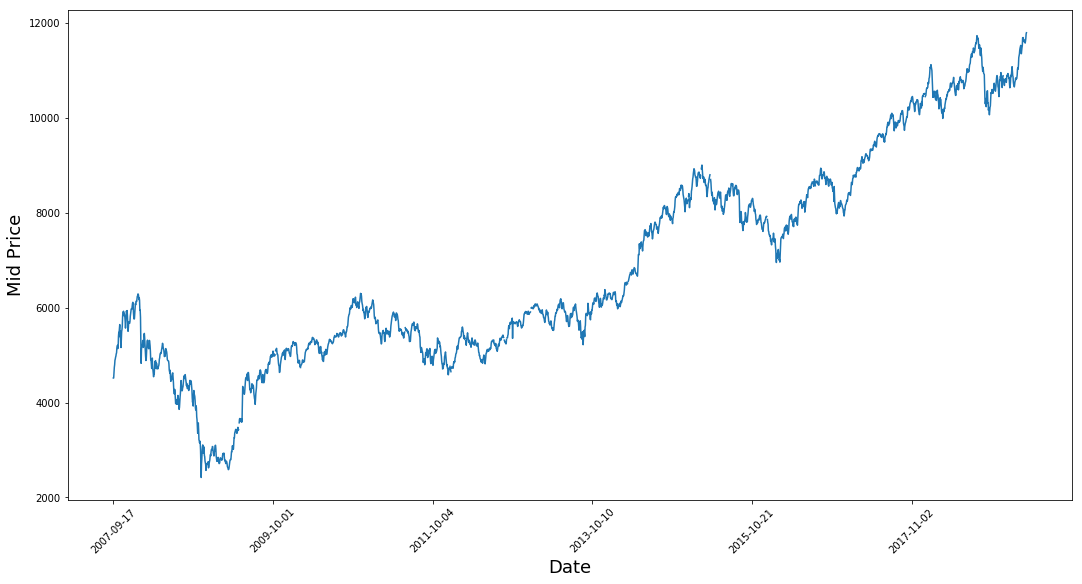

In [4]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## Step 2 - Data preprocessing 

In [5]:
df['mid'] = (df['Low']+df['High'])/2.0

In [6]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "mid"

In [7]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [8]:
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)

In [9]:
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [10]:
df = df.dropna()
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
mid       0
future    0
target    0
dtype: int64

In [11]:
df.head()

,Date,Open,High,Low,Close,Volume,mid,future,target
0,2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,0.0,4515.949951,4516.674805,1
1,2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,0.0,4516.674805,4644.625000,1
2,2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,0.0,4644.625000,4741.000000,1
3,2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,0.0,4741.000000,4794.700195,1
4,2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,0.0,4794.700195,4889.149902,1


In [12]:
times = sorted(df.index.values)  # get the times
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # get the last 10% of the times
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]  # get the last 20% of the times

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]  
train_df = df[(df.index < last_20pct)]  # now the train_df is all the data up to the last 20%

In [13]:
from collections import deque
import numpy as np
import random

In [14]:
train_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
validation_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
test_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)# don't need this anymore.

/home/abhishek/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
train_df.head()

,mid,target
0,4515.949951,1
1,4516.674805,1
2,4644.625000,1
3,4741.000000,1
4,4794.700195,1


In [16]:
train_data = train_df[RATIO_TO_PREDICT].as_matrix()
valid_data = validation_df[RATIO_TO_PREDICT].as_matrix()
test_data = test_df[RATIO_TO_PREDICT].as_matrix()

/home/abhishek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/abhishek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/abhishek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)


In [18]:
train_data.shape

(2246, 1)

In [19]:
scaler = MinMaxScaler()

In [20]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 400
for di in range(0,2000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [21]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data and validation data
valid_data = scaler.transform(valid_data).reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

In [22]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 1
for ti in range(2246):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,valid_data, test_data],axis=0)

In [23]:
X_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data)):
    X_train.append(train_data[i-SEQ_LEN:i])
    y_train.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [24]:
X_valid = []
y_valid = []
for i in range(SEQ_LEN, len(valid_data)):
    X_valid.append(valid_data[i-SEQ_LEN:i])
    y_valid.append(valid_data[i+(FUTURE_PERIOD_PREDICT-1)])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [25]:
X_test = []
y_test = []
for i in range(SEQ_LEN, len(test_data)):
    X_test.append(test_data[i-SEQ_LEN:i])
    y_test.append(test_data[i+(FUTURE_PERIOD_PREDICT-1)])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [26]:
y_train.shape

(2186,)

In [27]:
y_test.shape

(220,)

In [28]:
y_train[2100]

0.8211399976927392

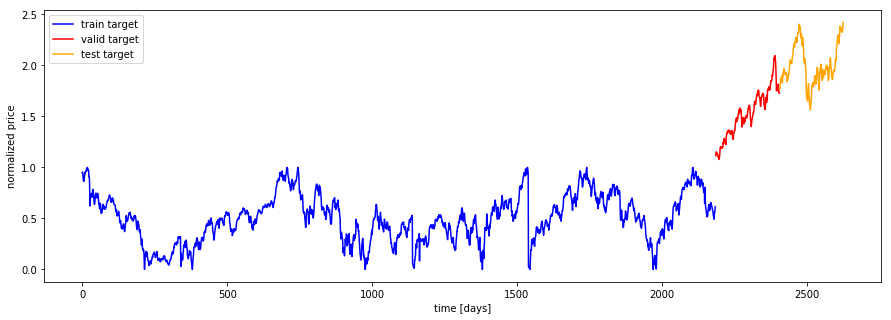

In [29]:
## show predictions
plt.figure(figsize=(15, 5))
plt.plot(np.arange(y_train.shape[0]), y_train, color='blue', label='train target')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid, color='red', label='valid target')
plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0], y_train.shape[0]+y_valid.shape[0]+y_test.shape[0]), y_test, color='orange', label='test target')

plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

In [30]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [31]:
EPOCHS = 10  # how many passes through our data
BATCH_SIZE = 64  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
import time

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

# MODEL

In [42]:
!pip install -q tensorflow==2.0.0-alpha0

In [60]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 1))
    #LSTM before attention layers
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)      

    model = Model(inputs = inp, outputs = x)
    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
    
    # Save entire model to a HDF5 file
    #model.save('my_model.h5')
    
    return model

In [61]:
multi_head = build_model()

In [63]:
multi_head.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 60, 256)      133120      input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 128)      164352      bidirectional[0][0]              
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 60, 192)      24576       bidirectional_1[0][0]            
____________________________________________________________________________________________

In [64]:
multi_head.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid), 
                    #callbacks = [checkpoint , lr_reduce]
             )

Train on 2186 samples, validate on 221 samples
Epoch 1/10
2186/2186 [==============================] - 13s 6ms/sample - loss: 0.0525 - accuracy: 0.0032 - val_loss: 0.5727 - val_accuracy: 0.0000e+00
Epoch 2/10
2186/2186 [==============================] - 12s 5ms/sample - loss: 0.0199 - accuracy: 0.0050 - val_loss: 0.6791 - val_accuracy: 0.0000e+00
Epoch 3/10
2186/2186 [==============================] - 12s 6ms/sample - loss: 0.0168 - accuracy: 0.0050 - val_loss: 0.4443 - val_accuracy: 0.0000e+00
Epoch 4/10
2186/2186 [==============================] - 13s 6ms/sample - loss: 0.0113 - accuracy: 0.0055 - val_loss: 0.4744 - val_accuracy: 0.0000e+00
Epoch 5/10
2186/2186 [==============================] - 11s 5ms/sample - loss: 0.0078 - accuracy: 0.0055 - val_loss: 0.4760 - val_accuracy: 0.0000e+00
Epoch 6/10
2186/2186 [==============================] - 11s 5ms/sample - loss: 0.0070 - accuracy: 0.0055 - val_loss: 0.4679 - val_accuracy: 0.0000e+00
Epoch 7/10
2186/2186 [=========================

In [65]:
predicted_stock_price_multi_head = multi_head.predict(X_test)
#predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


predicted_stock_price_multi_head.shape

(220, 1)

In [66]:
predicted_stock_price_multi_head = np.vstack((np.full((60,1), np.nan), predicted_stock_price_multi_head))

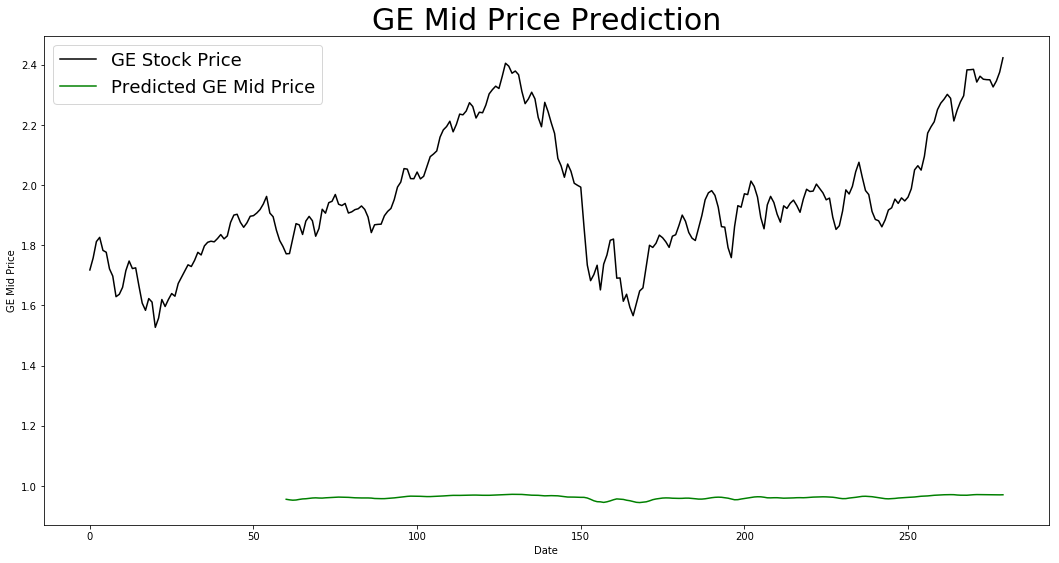

In [68]:
plt.figure(figsize = (18,9))
plt.plot(test_data, color = 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_multi_head, color = 'green', label = 'Predicted GE Mid Price')
plt.title('GE Mid Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Mid Price')
plt.legend(fontsize=18)
plt.show()

In [69]:
pre = predicted_stock_price_multi_head
pre  = scaler.inverse_transform(pre)
pre  = np.dot(pre, 1.2)
real_y_test = np.reshape(y_test,(-1,1))
real_y_test = scaler.inverse_transform(real_y_test)

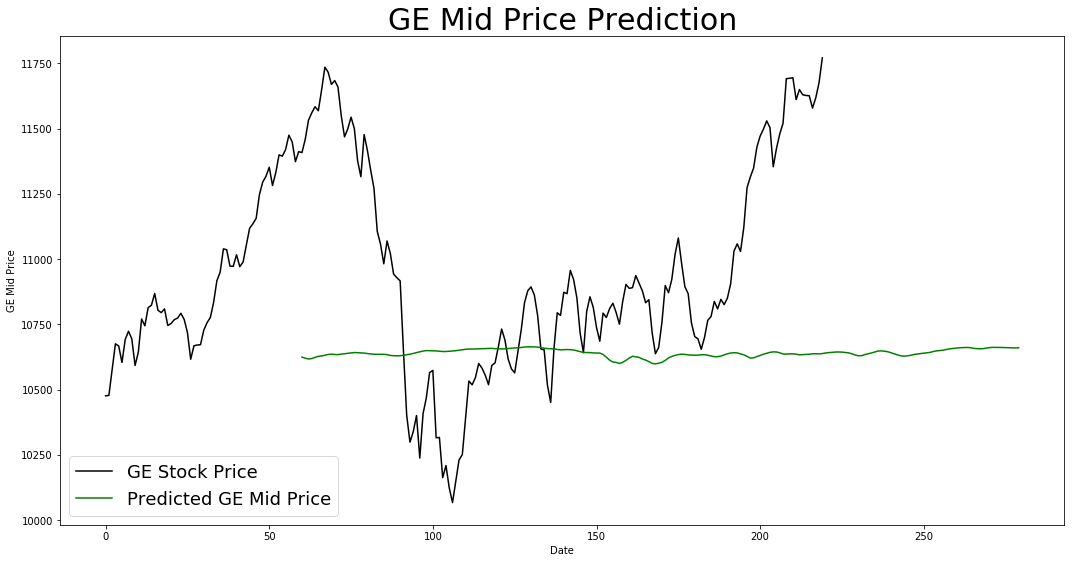

In [70]:
plt.figure(figsize = (18,9))
plt.plot(real_y_test, color = 'black', label = 'GE Stock Price')
plt.plot(pre, color = 'green', label = 'Predicted GE Mid Price')
plt.title('GE Mid Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Mid Price')
plt.legend(fontsize=18)
plt.show()